In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install albumentations
!pip install opencv-python


Running on device: cuda


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-3-971405319>:39: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 161MB/s]



Epoch 1/30
----------


<ipython-input-3-971405319>:104: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-3-971405319>:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


train Loss: 0.9094 Acc: 0.6671
val Loss: 0.7595 Acc: 0.8377
Best model saved!

Epoch 2/30
----------
train Loss: 0.7142 Acc: 0.8290
val Loss: 0.6360 Acc: 0.8950
Best model saved!

Epoch 3/30
----------
train Loss: 0.6311 Acc: 0.8582
val Loss: 0.5858 Acc: 0.8994
Best model saved!

Epoch 4/30
----------
train Loss: 0.5919 Acc: 0.8725
val Loss: 0.5508 Acc: 0.9069
Best model saved!

Epoch 5/30
----------
train Loss: 0.5702 Acc: 0.8798
val Loss: 0.5305 Acc: 0.9113
Best model saved!

Epoch 6/30
----------
train Loss: 0.5592 Acc: 0.8855
val Loss: 0.5221 Acc: 0.9123
Best model saved!

Epoch 7/30
----------
train Loss: 0.5521 Acc: 0.8836
val Loss: 0.5126 Acc: 0.9156
Best model saved!

Epoch 8/30
----------
train Loss: 0.5448 Acc: 0.8890
val Loss: 0.5154 Acc: 0.9123

Epoch 9/30
----------
train Loss: 0.5448 Acc: 0.8863
val Loss: 0.5061 Acc: 0.9134

Epoch 10/30
----------
train Loss: 0.5379 Acc: 0.8926
val Loss: 0.5097 Acc: 0.9113

Epoch 11/30
----------
train Loss: 0.5503 Acc: 0.8809
val Loss: 0

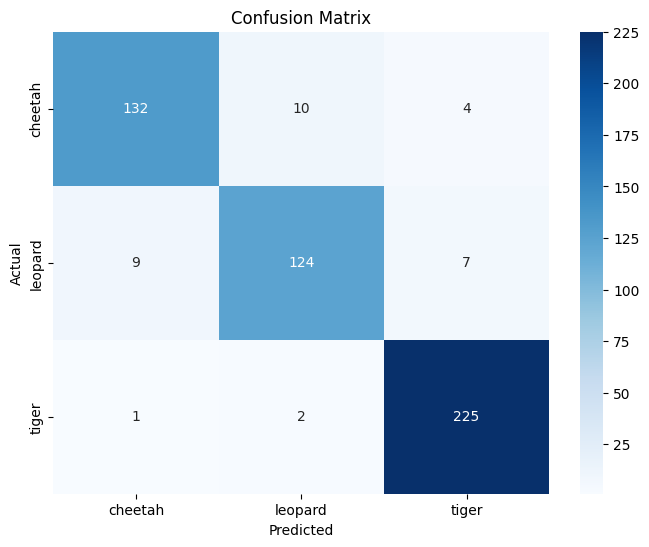

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import time, copy, os
from sklearn.metrics import confusion_matrix, classification_report
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# Paths
train_dir = '/content/drive/MyDrive/Datasets-train'
test_dir = '/content/drive/MyDrive/Datasets-test'
input_size = 224

# Albumentations transforms
train_transforms = A.Compose([
    A.Resize(input_size, input_size),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.OneOf([
        A.GaussianBlur(p=0.5),
        A.MotionBlur(p=0.5),
        A.GaussNoise(p=0.5)
    ], p=0.3),
    A.RandomShadow(p=0.3),
    A.RandomFog(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

val_test_transforms = A.Compose([
    A.Resize(input_size, input_size),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

# Custom Albumentations Dataset
class AlbumentationsDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.dataset = datasets.ImageFolder(folder)
        self.transform = transform
        self.classes = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

# Load datasets
full_train_dataset = AlbumentationsDataset(train_dir, transform=train_transforms)
class_names = full_train_dataset.classes
num_classes = len(class_names)

# Split into train & val
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transforms

test_dataset = AlbumentationsDataset(test_dir, transform=val_test_transforms)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Load EfficientNetV2 model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = GradScaler()

# Training function
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=30, patience=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    counter = 0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-'*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss, running_corrects = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), 'best_model.pth')
                    print("Best model saved!")
                    counter = 0
                else:
                    counter += 1
                if counter >= patience:
                    print("Early stopping triggered.")
                    model.load_state_dict(best_model_wts)
                    return model

    model.load_state_dict(best_model_wts)
    return model

# Start training
model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=30)

# Load best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))

# Evaluation function
def evaluate(model, test_loader, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    print(f'\nTest Accuracy: {acc*100:.2f}%')
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Run evaluation
evaluate(model, test_loader, class_names)


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import os

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class names (same as training dataset order)
class_names = ['cheetah', 'leopard', 'tiger']
num_classes = len(class_names)

# Define transforms for inference
inference_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

# Load model architecture
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model.pth'))
model.to(device)
model.eval()

# Prediction function
def predict_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augmented = inference_transform(image=image)['image']
    input_tensor = augmented.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        confidence, predicted_class = torch.max(probabilities, 0)

    predicted_label = class_names[predicted_class.item()]
    confidence_score = confidence.item() * 100

    print(f"Predicted: {predicted_label} ({confidence_score:.2f}%)")
    return predicted_label, confidence_score

# Example usage:
# Replace this with your actual test image path
test_image_path = '/content/drive/MyDrive/Datasets-test/leopard/1465.jpg'
predict_image(test_image_path)


Predicted: leopard (57.22%)


('leopard', 57.22196698188782)

In [ ]:
# Export to TorchScript
example_input = torch.randn(1, 3, 224, 224).to(device)
traced_model = torch.jit.trace(model, example_input)

# Save TorchScript model
traced_model.save("/content/drive/MyDrive/efficientnetv2_model2_inference.pt")
print("TorchScript model exported!")


TorchScript model exported!
